In [1]:
import sys, os
modulepath = os.path.abspath("ssh_1d_cpp/build/bin-module/")
sys.path.insert(0,modulepath)

import ssh_1d
import numpy as np

N = 10
Ns = 2*N+1
psi0 = 0.01
t0=0.
t_end=1200
dt = 0.01

gamA = 0.16
# gamA = 0.48
gamB = gamA
gA = 0.44 + gamA
# gA = 0.06 + gamA
gB = 0
t1=1
t2=0.7

params = ssh_1d.TimeSeriesParams(N, psi0, gA, gB, gamA, gamB, t_end, dt, t1, t2)

time_series = ssh_1d.time_series(params)
t_values = time_series[:,0].real
psi_values = time_series[:,1:]

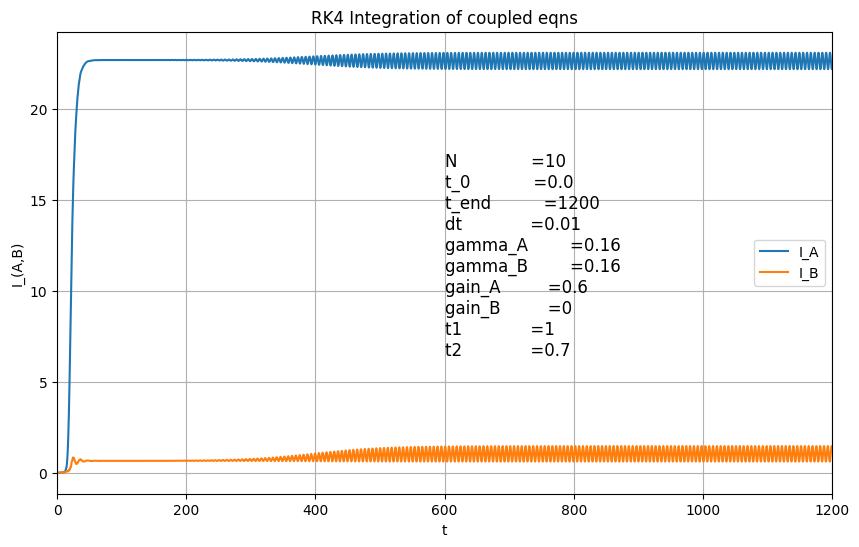

In [2]:
import matplotlib.pyplot as plt

t_values = time_series[:,0].real
psi_values = time_series[:,1:]

IA = np.sum(np.abs(psi_values[:,0::2])**2, axis=1)
IB = np.sum(np.abs(psi_values[:,1::2])**2, axis=1)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(t_values, IA, label='I_A')
ax.plot(t_values, IB, label='I_B')

ax.set_xlabel('t')
ax.set_ylabel('I_(A,B)')
ax.legend()
ax.set_title('RK4 Integration of coupled eqns')
# ax.set_xlim((400,600))
# ax.set_ylim((30.2499,30.2501))
ax.set_xmargin(0)
ax.grid(True)
params = {'N':N, 't_0':t0, 't_end': t_end, 'dt':dt, 'gamma_A':gamA, 'gamma_B':gamB, 'gain_A': gA, 'gain_B':gB, 't1':t1, 't2':t2}
paramtext = "\n".join([ f"{key:<15}={value:<6}" for key, value in params.items()])
ax.text(x=.5, y=.3,s=paramtext, color='black', transform=ax.transAxes, size=12)

plt.show()

In [3]:
#phase diagram as in fig 1b in paper
from numpy import fft
import concurrent.futures

def phase_diagram():
    numx = 50
    numy = 50

    x_ = np.linspace(0,.5,numx) # gamma_AB
    y_ = np.linspace(0,0.5,numy) # g_A - gamma_AB

    def oscillating_factor_worker(x,y):
        gamA = x
        params = ssh_1d.TimeSeriesParams(N=10, psi0=0.01, satGainA=y+gamA, satGainB=0.,
                                        gammaA=gamA, gammaB=gamA, time_end=1200, time_delta=0.01,
                                        t1=1., t2=0.7)
        time_series = ssh_1d.time_series(params)
        t_values = time_series[:,0].real
        psi_values = time_series[:,1:]

        time_filter = (850<t_values)*(t_values<900)
        psi_fft = fft.fft(psi_values[time_filter,:], axis=0)
        psi_fft_all_sites = np.sum(np.abs(psi_fft)**2, axis=1)
        return np.max(psi_fft_all_sites[1:])

    xy_pairs = np.array([(x,y) for y in y_ for x in x_])
    oscillating_factors = []

    with concurrent.futures.ThreadPoolExecutor(max_workers=20) as executor:
        futures = [executor.submit(oscillating_factor_worker, *(xy_pair)) for xy_pair in xy_pairs]
        oscillating_factors = [future.result() for future in futures]

    fig, ax = plt.subplots(figsize=(5, 5))

    x = xy_pairs[:,0]
    y = xy_pairs[:,1]
    ax.scatter(x,y, c=np.array(oscillating_factors)>8000, cmap='coolwarm')

    ax.set_xlabel('gamma_AB')
    ax.set_ylabel('g_A - gamma_AB')
    ax.set_title('phase diagram')
    ax.set_xmargin(0)
    ax.set_ymargin(0)
    ax.grid(True)

# phase_diagram()

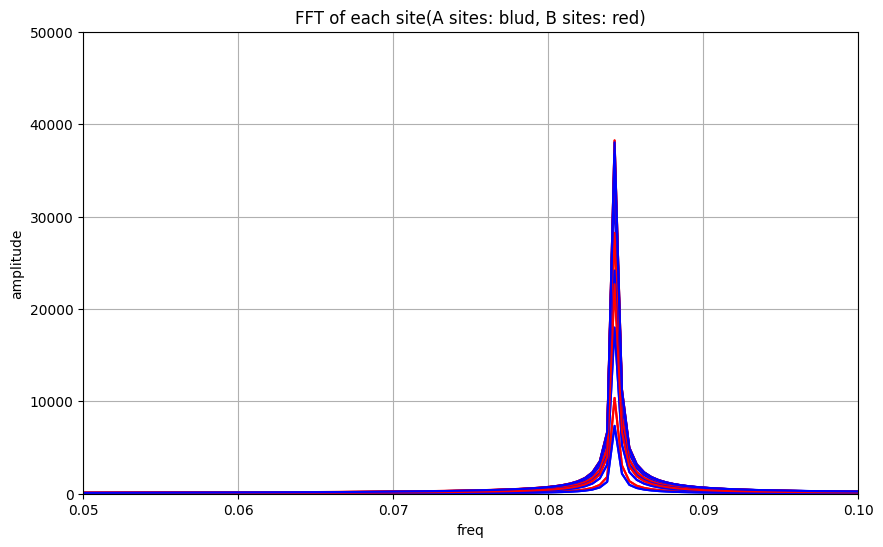

In [4]:
from numpy import fft
x = 0.16
y= .44
gamA = x
params = ssh_1d.TimeSeriesParams(N=10, psi0=0.01, satGainA=y+gamA, satGainB=0.,
                                     gammaA=gamA, gammaB=gamA, time_end=2500, time_delta=0.01,
                                     t1=1., t2=0.7)
time_series = ssh_1d.time_series(params)
t_values = time_series[:,0].real
psi_values = time_series[:,1:]



time_filter = (400<t_values)*(t_values<2500)
psi_fft = fft.fft(psi_values[time_filter,:], axis=0)
Nt = len(t_values[time_filter])
f_values = np.fft.fftfreq(Nt, d=0.01)
right_half_filter = f_values>=0


fig, ax = plt.subplots(figsize=(10, 6))

for site_index in range(Ns):
    color = 'b' if site_index%2==0 else 'r'
    ax.plot(f_values[right_half_filter], np.abs(psi_fft[right_half_filter,site_index]), c=color)

ax.set_xlabel('freq')
ax.set_ylabel('amplitude')
ax.set_title('FFT of each site(A sites: blud, B sites: red)')
ax.set_xlim((0.05,.1))
ax.set_ylim((0,5e4))
ax.set_xmargin(0)
ax.grid(True)
plt.show()

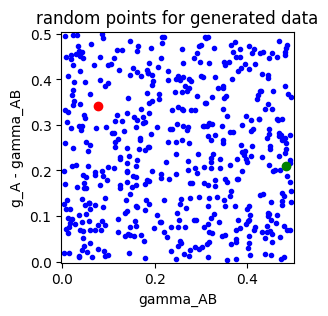

In [43]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42) #for reproducibility

num_time_series = 500

data1_index = 4
data2_index = 11
x_ = np.random.uniform(0, 0.5, num_time_series)
y_ = np.random.uniform(0, 0.5, num_time_series)

fig, ax = plt.subplots(figsize=(3, 3))
ax.scatter(x_, y_, color='blue', marker='.')
ax.scatter(x_[data1_index],y_[data1_index], color='red')
ax.scatter(x_[data2_index],y_[data2_index], color='green')
ax.set_xlabel('gamma_AB')
ax.set_ylabel('g_A - gamma_AB')
ax.set_title('random points for generated data')
ax.set_xmargin(0.01)
ax.set_ymargin(0.01)
plt.show()


In [28]:
#generate data
import concurrent.futures
import h5py

tsfilename = 'time_series.hdf5'
h5py.File(tsfilename, 'w').close() #must create empty existing file to avoid overloading python memory
time_sample_size = 1000

def time_series_worker(i, x,y):
    gamA = x
    params = ssh_1d.TimeSeriesParams(N=10, psi0=0.01, satGainA=y+gamA, satGainB=0.,
                                     gammaA=gamA, gammaB=gamA, time_end=1200, time_delta=0.01,
                                     t1=1., t2=0.7)
    time_series = ssh_1d.time_series(params)
    time_series = time_series[1799:,:] # start from 1800-th time step
    samp_indices = np.round(np.linspace(0,time_series.shape[0]-1,time_sample_size)).astype(int)
    with h5py.File(tsfilename, 'a') as tsfile:
        data = time_series[samp_indices,:]
        dataset = tsfile.create_dataset(name=f'series_{i}', data = data)
        dataset.attrs['x'] = x
        dataset.attrs['y'] = y
        dataset.attrs['N'] = 10
        tsfile.flush()
    return 'success'

xy_pairs = np.array([(x,y) for x,y in zip(x_,y_)])


with concurrent.futures.ThreadPoolExecutor(max_workers=20) as executor:
    futures = [executor.submit(time_series_worker, i, *(xy_pair)) for i, xy_pair in enumerate(xy_pairs)]


oscillating: x,y: 0.07800932022121826 0.34236558627693964
static: x,y: 0.48495492608099716 0.20912151814530944
U,S,Vh shapes:  (21, 21) (21,) (21, 1000)
U,S,Vh shapes:  (21, 21) (21,) (21, 1000)


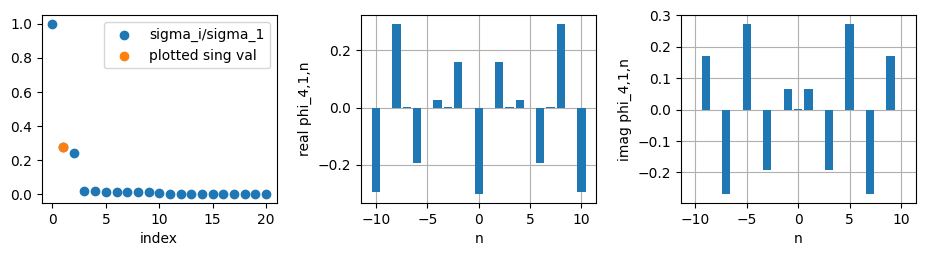

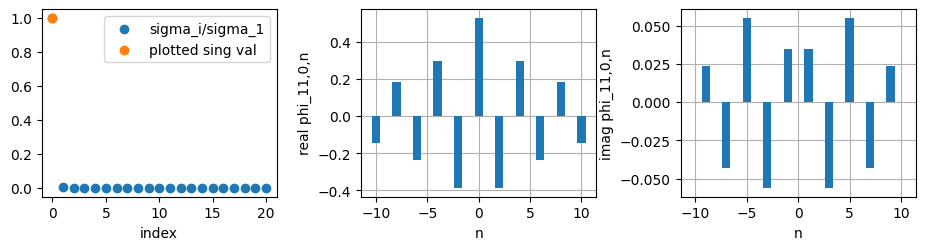

In [3]:
# svd: POD (supp. mat. sec A)
# https://static-content.springer.com/esm/art%3A10.1038%2Fs42005-023-01230-z/MediaObjects/42005_2023_1230_MOESM2_ESM.pdf
import h5py
from numpy import linalg
import matplotlib.pyplot as plt
import numpy as np
tsfilename = 'time_series.hdf5'



def plot_pod(time_series, data_index, singval_index):
    t_values = time_series[:,0].real.T
    psi_values = time_series[:,1:].T

    Ns,Nt = psi_values.shape
    N0 = np.min([Nt,Ns])
    N = int((Ns-1)/2)

    U, S, Vh = linalg.svd(psi_values, full_matrices=False)
    print("U,S,Vh shapes: ", U.shape, S.shape, Vh.shape)

    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10, 3))
    fig.tight_layout(pad=3)
    ax1.scatter(range(len(S)),S/S[0], label='sigma_i/sigma_1')
    ax1.scatter(singval_index,S[singval_index]/S[0], label='plotted sing val')
    ax1.legend()
    ax1.set_xlabel("index")

    ax2.bar(np.arange(-N,N+1), U[:,singval_index].real)
    ax2.grid()
    ax2.set_axisbelow(True)
    ax2.set_ylabel(f'real phi_{data_index},{singval_index},n')
    ax2.set_xlabel('n')

    ax3.bar(np.arange(-N,N+1), U[:,singval_index].imag)
    ax3.grid()
    ax3.set_axisbelow(True)
    ax3.set_ylabel(f'imag phi_{data_index},{singval_index},n')
    ax3.set_xlabel('n')

data1_index = 4
data2_index = 11

file = h5py.File(tsfilename, 'r')
data1 = file[f'series_{data1_index}']
data2 = file[f'series_{data2_index}']
print('oscillating: x,y:', data1.attrs['x'],data1.attrs['y'])
print('static: x,y:', data2.attrs['x'],data2.attrs['y'])
N = data1.attrs['N']
plot_pod(time_series=data1[:], data_index=data1_index, singval_index=1)
plot_pod(time_series=data2[:], data_index=data2_index, singval_index=0)
file.close()

### Supplementary information: section B:


$$X_2=AX_1$$
Do truncated svd of $X_1 = U_r\Sigma_rV_r^\dagger$,

$$\implies X_2 = AU_r\Sigma_rV_r^\dagger$$

Find $A$ in truncated POD subspace, i.e. $A_r$:

$$A_r=U_r^\dagger AU_r = U_r^\dagger X_2V_r\Sigma_r^{-1}$$

Eigen-decompose $A_r$:

$$A_rW=\Lambda W$$

But since $A\Phi = \Lambda\Phi$ and $A_r\approx U_r^\dagger AU_r$, we know the transformation 
$$ \Phi = U_rW$$
Substitute the $U_r$ using the SVD of $X_1$ to get
$$\Phi = X_1V_r\Sigma_r^{-1}W$$
which we can evolve by left multiplying both sides by $A$
$$\Lambda\Phi = X_2V_r\Sigma_r^{-1}W$$

### Calculation plan:
#### Size fit confirm
Let $X_{1,2}$ be time series data of size $N_s\times N_t$, with $N_r$ being the size of truncated matrices below. 
Since $W$ is eigen vectors of $A_r$, $W$ has square size $N_r$ too. 
So $X_2$ is $N_t$ columns and $X_2V_r\Sigma_r^{-1}$ is $N_s\times N_r$, the size of $\Phi$

#### Calculation steps
1. Grab two time snapshots $X_{1,2}$
1. Find SVD of $X_1$ truncated to $r$:  $X_1=U_r\Sigma_r V_r^\dagger$
1. Project $A$ into POD subspace:  $A_r =U_r^\dagger X_2V_r\Sigma_r^{-1}$
1. Find eigenvectors $W$ of $A_r$
1. Obtain $\Phi$ using formula from prev. section.


In [4]:
# svd: DMD (supp. mat. sec B)
import h5py
from numpy import linalg
import matplotlib.pyplot as plt
import numpy as np
tsfilename = 'time_series.hdf5'

def trunc_svd(mat, r_threshold = 0.99, full_matrices=False):
    U, S, Vh = linalg.svd(mat, full_matrices=full_matrices)
    r = len(S)
    s_cummulative = 0
    s_threshold = np.sum(S)*r_threshold
    for i, s in enumerate(S):
        s_cummulative+=s
        if s_cummulative > s_threshold:
            r = i+1
            break
    return (U[:,:r], S[:r,], Vh[:r,:], r)



def plot_dmd(time_series, data_index, singval_index):
    t_values = time_series[:,0].real.T
    psi_values = time_series[:,1:].T

    Ns,Nt = psi_values.shape
    N0 = np.min([Nt,Ns])
    N = int((Ns-1)/2)

    X1 = psi_values[:,0:Ns]


    # A = X2 @ linalg.inv(X1)
    # print("X1,X2,A shapes:", X1.shape, X2.shape, A.shape)

    # lambdas, Phi = linalg.eig(A)
    # print("lambdas, Phi shapes:", lambdas.shape, Phi.shape)

    U, S, Vh, r = trunc_svd(X1)
    print("U,S,Vh shapes and r: ", U.shape, S.shape, Vh.shape, r)
    X2 = A

    # U, S, Vh = linalg.svd(psi_values, full_matrices=False)

    # fig, ((ax1,ax2),(ax3, ax4)) = plt.subplots(2,2,figsize=(6, 6))
    # fig.tight_layout(pad=3)
    # ax1.scatter(range(len(S)),S/S[0], label='sigma_i/sigma_1')
    # ax1.scatter(singval_index,S[singval_index]/S[0], label='plotted sing val')
    # ax1.legend()
    # ax1.set_xlabel("index")

    # ax3.bar(np.arange(-N,N+1), U[:,singval_index].real)
    # ax3.grid()
    # ax3.set_axisbelow(True)
    # ax3.set_ylabel(f'real phi_{data_index},{singval_index},n')
    # ax3.set_xlabel('n')

    # ax4.bar(np.arange(-N,N+1), U[:,singval_index].imag)
    # ax4.grid()
    # ax4.set_axisbelow(True)
    # ax4.set_ylabel(f'imag phi_{data_index},{singval_index},n')
    # ax4.set_xlabel('n')

data1_index = 4
data2_index = 11

file = h5py.File(tsfilename, 'r')
data1 = file[f'series_{data1_index}']
data2 = file[f'series_{data2_index}']
print('oscillating: x,y:', data1.attrs['x'],data1.attrs['y'])
print('static: x,y:', data2.attrs['x'],data2.attrs['y'])
N = data1.attrs['N']
plot_dmd(time_series=data1[:], data_index=data1_index, singval_index=1)
plot_dmd(time_series=data2[:], data_index=data2_index, singval_index=0)
file.close()

oscillating: x,y: 0.07800932022121826 0.34236558627693964
static: x,y: 0.48495492608099716 0.20912151814530944
U,S,Vh shapes and r:  (21, 10) (10,) (10, 21) 10
[17.34072986  2.90780783  1.2129454   1.14773946  0.60521529  0.54798388
  0.42324619  0.41013389  0.3881777   0.18721759]
U,S,Vh shapes and r:  (21, 2) (2,) (2, 21) 2
[3.62171714 0.17228439]


In [10]:
# https://bitbucket.org/topologicalphotonics/pti_dynamic_model/src/master/src/run_ssh_sat_gain.cpp
